In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime

import tqdm
import re
from string import punctuation
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import keras.backend as K
import tensorflow as tf

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

Using TensorFlow backend.
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Future

In [2]:
#env = nflrush.make_env()

In [3]:
train = pd.read_csv('nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})

# Overall analysis

In [4]:
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


## Feature Engineering

In [5]:
#from https://www.kaggle.com/prashantkikani/nfl-starter-lgb-feature-engg
train['DefendersInTheBox_vs_Distance'] = train['DefendersInTheBox'] / train['Distance']

# Categorical features

In [6]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))

In [7]:
cat_features

[('Team', 2),
 ('DisplayName', 2230),
 ('GameClock', 901),
 ('PossessionTeam', 32),
 ('FieldPosition', 33),
 ('OffenseFormation', 9),
 ('OffensePersonnel', 56),
 ('DefensePersonnel', 38),
 ('PlayDirection', 2),
 ('TimeHandoff', 22935),
 ('TimeSnap', 22943),
 ('PlayerHeight', 16),
 ('PlayerBirthDate', 1688),
 ('PlayerCollegeName', 301),
 ('Position', 25),
 ('HomeTeamAbbr', 32),
 ('VisitorTeamAbbr', 32),
 ('Stadium', 55),
 ('Location', 60),
 ('StadiumType', 30),
 ('Turf', 20),
 ('GameWeather', 62),
 ('WindSpeed', 41),
 ('WindDirection', 54)]

Let's preprocess some of those features.

## Stadium Type

In [8]:
train['StadiumType'].value_counts()

Outdoor                   267696
Outdoors                   67474
Indoors                    40854
Dome                       17336
Indoor                     16148
Retractable Roof           15884
Open                        9614
Retr. Roof-Closed           7172
Retr. Roof - Closed         6446
Domed, closed               5918
Domed, open                 2684
Closed Dome                 2134
Dome, closed                1826
Domed                       1826
Oudoor                      1188
Indoor, Roof Closed         1056
Retr. Roof Closed           1056
Retr. Roof-Open              990
Bowl                         968
Outddors                     968
Heinz Field                  902
Outdoor Retr Roof-Open       880
Retr. Roof - Open            880
Ourdoor                      858
Outdor                       858
Indoor, Open Roof            858
Outside                      814
Cloudy                       770
Domed, Open                  770
Name: StadiumType, dtype: int64

We already can see some typos, let's fix them.

In [9]:
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

In [10]:
train['StadiumType'] = train['StadiumType'].apply(clean_StadiumType)

By pareto's principle we are just going to focus on the words: outdoor, indoor, closed and open.

In [11]:
def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    
    return np.nan

In [12]:
train['StadiumType'] = train['StadiumType'].apply(transform_StadiumType)

## Turf

In [13]:
#from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

train['Turf'] = train['Turf'].map(Turf)
train['Turf'] = train['Turf'] == 'Natural'

## Possession Team

In [14]:
train[(train['PossessionTeam']!=train['HomeTeamAbbr']) & (train['PossessionTeam']!=train['VisitorTeamAbbr'])][['PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr']]

,PossessionTeam,HomeTeamAbbr,VisitorTeamAbbr
2992,BLT,CIN,BAL
2993,BLT,CIN,BAL
2994,BLT,CIN,BAL
2995,BLT,CIN,BAL
2996,BLT,CIN,BAL
2997,BLT,CIN,BAL
2998,BLT,CIN,BAL
2999,BLT,CIN,BAL
3000,BLT,CIN,BAL
3001,BLT,CIN,BAL


We have some problem with the enconding of the teams such as BLT and BAL or ARZ and ARI.

Let's try to fix them manually.

In [15]:
sorted(train['HomeTeamAbbr'].unique()) == sorted(train['VisitorTeamAbbr'].unique())

True

In [16]:
diff_abbr = []
for x,y  in zip(sorted(train['HomeTeamAbbr'].unique()), sorted(train['PossessionTeam'].unique())):
    if x!=y:
        print(x + " " + y)

ARI ARZ
BAL BLT
CLE CLV
HOU HST


Apparently these are the only three problems, let's fix it.

In [17]:
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train['PossessionTeam'].unique():
    map_abbr[abb] = abb

In [18]:
train['PossessionTeam'] = train['PossessionTeam'].map(map_abbr)
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].map(map_abbr)
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].map(map_abbr)

In [19]:
train['HomePossesion'] = train['PossessionTeam'] == train['HomeTeamAbbr']

In [20]:
train['Field_eq_Possession'] = train['FieldPosition'] == train['PossessionTeam']
train['HomeField'] = train['FieldPosition'] == train['HomeTeamAbbr']

## Offense formation

In [21]:
off_form = train['OffenseFormation'].unique()
train['OffenseFormation'].value_counts()

SINGLEBACK    225434
SHOTGUN       150964
I_FORM        106062
PISTOL         13420
JUMBO          11462
WILDCAT         1782
EMPTY            506
ACE               22
Name: OffenseFormation, dtype: int64

Since I don't have any knowledge about formations, I am just goig to one-hot encode this feature

In [22]:
train = pd.concat([train.drop(['OffenseFormation'], axis=1), pd.get_dummies(train['OffenseFormation'], prefix='Formation')], axis=1)
dummy_col = train.columns

## Game Clock

Game clock is supposed to be a numerical feature.

In [23]:
train['GameClock'].value_counts()

15:00:00    14476
02:00:00     5236
14:54:00     2156
14:55:00     1958
14:56:00     1276
14:20:00     1188
14:25:00     1144
14:53:00     1078
14:24:00     1078
14:22:00     1056
01:54:00     1012
14:19:00      990
14:21:00      968
14:28:00      946
11:26:00      924
14:23:00      924
14:16:00      924
02:39:00      924
14:26:00      902
03:55:00      902
02:23:00      880
02:32:00      880
05:46:00      880
01:53:00      858
12:54:00      858
14:15:00      858
04:35:00      858
14:17:00      836
09:33:00      836
13:05:00      836
            ...  
14:06:00      264
00:14:00      264
14:46:00      264
14:34:00      264
14:02:00      264
14:45:00      264
14:07:00      242
00:09:00      242
01:45:00      242
05:06:00      242
14:36:00      242
13:57:00      242
00:06:00      220
14:31:00      220
00:02:00      220
00:07:00      220
14:41:00      220
14:48:00      220
12:45:00      220
14:44:00      198
14:00:00      176
14:43:00      176
14:42:00      132
14:38:00      132
00:01:00  

Since we already have the quarter feature, we can just divide the Game Clock by 15 minutes so we can get the normalized time left in the quarter.

In [24]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

In [25]:
train['GameClock'] = train['GameClock'].apply(strtoseconds)

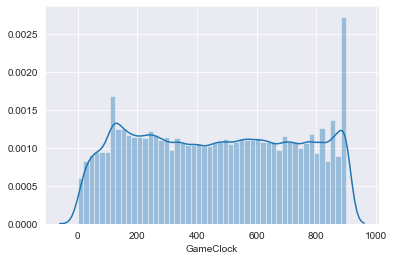

In [26]:
sns.distplot(train['GameClock'])

## Player height

In [27]:
train['PlayerHeight']

0          6-0
1          6-3
2          6-3
3          6-3
4          6-0
5          6-2
6         5-11
7          6-0
8          6-2
9          6-0
10         6-6
11        5-11
12         6-6
13         6-6
14         6-9
15         6-4
16         6-1
17        5-10
18        5-10
19         6-1
20         6-3
21         6-5
22         6-0
23         6-3
24         6-3
25         6-3
26         6-0
27         6-2
28        5-11
29         6-0
          ... 
509732    5-11
509733     6-6
509734    5-10
509735     6-5
509736     6-5
509737     6-6
509738     6-0
509739    5-11
509740     6-3
509741     6-1
509742    5-11
509743     6-5
509744     6-2
509745     6-1
509746     6-1
509747     6-3
509748     6-4
509749     6-1
509750    5-10
509751     6-4
509752     6-4
509753    5-11
509754     6-3
509755     6-6
509756     6-2
509757     6-6
509758     6-5
509759     6-5
509760     6-6
509761    5-11
Name: PlayerHeight, Length: 509762, dtype: object

We know that 1ft=12in, thus:

In [28]:
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

In [29]:
train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)

## Time handoff and snap and Player BirthDate

In [30]:
train['TimeHandoff']

0         2017-09-08T00:44:06.000Z
1         2017-09-08T00:44:06.000Z
2         2017-09-08T00:44:06.000Z
3         2017-09-08T00:44:06.000Z
4         2017-09-08T00:44:06.000Z
5         2017-09-08T00:44:06.000Z
6         2017-09-08T00:44:06.000Z
7         2017-09-08T00:44:06.000Z
8         2017-09-08T00:44:06.000Z
9         2017-09-08T00:44:06.000Z
10        2017-09-08T00:44:06.000Z
11        2017-09-08T00:44:06.000Z
12        2017-09-08T00:44:06.000Z
13        2017-09-08T00:44:06.000Z
14        2017-09-08T00:44:06.000Z
15        2017-09-08T00:44:06.000Z
16        2017-09-08T00:44:06.000Z
17        2017-09-08T00:44:06.000Z
18        2017-09-08T00:44:06.000Z
19        2017-09-08T00:44:06.000Z
20        2017-09-08T00:44:06.000Z
21        2017-09-08T00:44:06.000Z
22        2017-09-08T00:44:27.000Z
23        2017-09-08T00:44:27.000Z
24        2017-09-08T00:44:27.000Z
25        2017-09-08T00:44:27.000Z
26        2017-09-08T00:44:27.000Z
27        2017-09-08T00:44:27.000Z
28        2017-09-08

In [31]:
train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

In [32]:
train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)

In [33]:
train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

Let's use the time handoff to calculate the players age

In [34]:
seconds_in_year = 60*60*24*365.25
train['PlayerAge'] = train.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)

In [35]:
train = train.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)

## Wind Speed and Direction

In [36]:
train['WindSpeed'].value_counts()

5                    53284
6                    41580
7                    39578
4                    34584
9                    31328
10                   29788
8                    29370
3                    26862
2                    24112
12                   23584
11                   17116
15                   13926
0                    13772
1                    12078
16                    9878
13                    8404
14                    6094
17                    3872
18                    1980
13 MPH                1804
23                    1166
E                     1144
SE                    1122
10-20                 1100
7 MPH                 1100
Calm                  1100
12-22                 1056
6 mph                 1034
20                    1012
12mph                  968
14-23                  968
24                     968
10mph                  902
4 MPh                  902
10MPH                  902
15 gusts up to 25      836
SSW                    836
2

We can see there are some values that are not standardized(e.g. 12mph), we are going to remove mph from all our values.

In [37]:
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)

In [38]:
train['WindSpeed'].value_counts()

5                    53284
6                    42614
7                    40678
4                    35486
10                   31592
9                    31328
8                    29370
3                    26862
12                   24552
2                    24112
11                   17116
15                   13926
0                    13772
1                    12078
13                   10208
16                    9878
14                    6094
17                    3872
18                    1980
23                    1166
e                     1144
se                    1122
10-20                 1100
calm                  1100
12-22                 1056
20                    1012
14-23                  968
24                     968
22                     836
ssw                    836
15 gusts up to 25      836
11-17                  726
19                     660
Name: WindSpeed, dtype: int64

In [39]:
#let's replace the ones that has x-y by (x+y)/2
# and also the ones with x gusts up to y
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)

In [40]:
def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1

In [41]:
train['WindSpeed'] = train['WindSpeed'].apply(str_to_float)

In [42]:
train['WindDirection'].value_counts()

NE                 30250
NW                 27236
SW                 25828
SE                 25784
WSW                24222
N                  23188
W                  22198
S                  21384
NNE                20394
South              20328
SSW                19910
WNW                19118
North              17182
NNW                14036
West               13618
SSE                13376
E                  12826
ENE                10802
ESE                 9878
East                7348
Northwest           4070
From SW             3872
Northeast           3652
NorthEast           3212
From S              3146
s                   2728
SouthWest           2134
Southeast           1936
W-NW                1804
Southwest           1804
West-Southwest      1386
8                   1144
1                   1122
North East          1100
East Southeast      1078
Calm                1056
West Northwest      1056
N-NE                1012
From W               990
From SSW             968


In [43]:
def clean_WindDirection(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = txt.replace('from', '')
    txt = txt.replace(' ', '')
    txt = txt.replace('north', 'n')
    txt = txt.replace('south', 's')
    txt = txt.replace('west', 'w')
    txt = txt.replace('east', 'e')
    return txt

In [44]:
train['WindDirection'] = train['WindDirection'].apply(clean_WindDirection)

In [45]:
train['WindDirection'].value_counts()

s       47586
n       40370
ne      38214
w       37532
sw      33638
nw      31306
se      27720
wsw     27522
nne     22374
wnw     21978
ssw     21736
e       21076
nnw     15928
sse     15202
ese     11638
ene     11550
8        1144
1        1122
calm     1056
13        836
Name: WindDirection, dtype: int64

In [46]:
def transform_WindDirection(txt):
    if pd.isna(txt):
        return np.nan
    
    if txt=='n':
        return 0
    if txt=='nne' or txt=='nen':
        return 1/8
    if txt=='ne':
        return 2/8
    if txt=='ene' or txt=='nee':
        return 3/8
    if txt=='e':
        return 4/8
    if txt=='ese' or txt=='see':
        return 5/8
    if txt=='se':
        return 6/8
    if txt=='ses' or txt=='sse':
        return 7/8
    if txt=='s':
        return 8/8
    if txt=='ssw' or txt=='sws':
        return 9/8
    if txt=='sw':
        return 10/8
    if txt=='sww' or txt=='wsw':
        return 11/8
    if txt=='w':
        return 12/8
    if txt=='wnw' or txt=='nww':
        return 13/8
    if txt=='nw':
        return 14/8
    if txt=='nwn' or txt=='nnw':
        return 15/8
    return np.nan

In [47]:
train['WindDirection'] = train['WindDirection'].apply(transform_WindDirection)

## PlayDirection

In [48]:
train['PlayDirection'].value_counts()

left     256454
right    253308
Name: PlayDirection, dtype: int64

In [49]:
train['PlayDirection'] = train['PlayDirection'].apply(lambda x: x.strip() == 'right')

## Team

In [50]:
train['Team'] = train['Team'].apply(lambda x: x.strip()=='home')

## Game Weather

In [51]:
train['GameWeather'].unique()

array(['Clear and warm', 'Sun & clouds', 'Sunny', 'Controlled Climate',
       'Mostly Sunny', 'Clear', nan, 'Indoor', 'Mostly Cloudy',
       'Mostly Coudy', 'Partly sunny', 'Partly Cloudy', 'Cloudy',
       'Sunny, highs to upper 80s', 'Indoors', 'Light Rain', 'Showers',
       'Partly cloudy', 'Partly Sunny', '30% Chance of Rain',
       'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
       'Rain', 'Cloudy, fog started developing in 2nd quarter', 'Coudy',
       'Rain likely, temps in low 40s.', 'Cold', 'N/A (Indoors)',
       'Clear skies', 'cloudy', 'Fair', 'Mostly cloudy',
       'Cloudy, chance of rain', 'Heavy lake effect snow', 'Party Cloudy',
       'Cloudy, light snow accumulating 1-3"', 'Cloudy and cold', 'Snow',
       'Hazy', 'Scattered Showers', 'Cloudy and Cool', 'N/A Indoor',
       'Rain Chance 40%', 'Clear and sunny', 'Mostly sunny',
       'Sunny and warm', 'Partly clear', 'Cloudy, 50% change of rain',
       'Clear and Sunny', '

We are going to apply the following preprocessing:
 
- Lower case
- N/A Indoor, N/A (Indoors) and Indoor => indoor Let's try to cluster those together.
- coudy and clouidy => cloudy
- party => partly
- sunny and clear => clear and sunny
- skies and mostly => ""

In [52]:
train['GameWeather'] = train['GameWeather'].str.lower()
indoor = "indoor"
train['GameWeather'] = train['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

In [53]:
train['GameWeather'].unique()

array(['clear and warm', 'sun & clouds', 'sunny', 'controlled climate',
       'clear', nan, 'indoor', 'cloudy', 'partly sunny', 'partly cloudy',
       'sunny, highs to upper 80s', 'light rain', 'showers',
       '30% chance of rain',
       'cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.',
       'rain', 'cloudy, fog started developing in 2nd quarter',
       'rain likely, temps in low 40s.', 'cold', 'fair',
       'cloudy, chance of rain', 'heavy lake effect snow',
       'cloudy, light snow accumulating 1-3"', 'cloudy and cold', 'snow',
       'hazy', 'scattered showers', 'cloudy and cool', 'rain chance 40%',
       'sunny and clear', 'sunny and warm', 'partly clear',
       'cloudy, 50% change of rain', 'sunny, windy', 'clear and cool',
       'overcast', 't: 51; h: 55; w: nw 10 mph', 'cloudy, rain',
       'rain shower', 'clear and cold', 'rainy', 'sunny and cold'],
      dtype=object)

Let's now look at the most common words we have in the weather description

In [54]:
from collections import Counter
weather_count = Counter()
for weather in train['GameWeather']:
    if pd.isna(weather):
        continue
    for word in weather.split():
        weather_count[word]+=1
        
weather_count.most_common()[:15]

[('cloudy', 193952),
 ('sunny', 127468),
 ('partly', 58256),
 ('clear', 55594),
 ('rain', 28952),
 ('indoor', 26950),
 ('controlled', 12540),
 ('climate', 12540),
 ('and', 10956),
 ('cloudy,', 4972),
 ('fair', 4972),
 ('snow', 4708),
 ('cold', 4510),
 ('of', 4026),
 ('light', 3608)]

To encode our weather we are going to do the following map:
 
- climate controlled or indoor => 3, sunny or sun => 2, clear => 1, cloudy => -1, rain => -2, snow => -3, others => 0
- partly => multiply by 0.5

I don't have any expercience with american football so I don't know if playing in a climate controlled or indoor stadium is good or not, if someone has a good idea on how to encode this it would be nice to leave it in the comments :)

In [55]:
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

In [56]:
train['GameWeather'] = train['GameWeather'].apply(map_weather)

## NflId NflIdRusher

In [57]:
train['IsRusher'] = train['NflId'] == train['NflIdRusher']

In [58]:
train.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)

## PlayDirection problems

As we can see, we have a problem if some features such as X and Y because of the play direction, let's fix those issues

### X, orientation and direction

In [59]:
train['X'] = train.apply(lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)

In [60]:
#from https://www.kaggle.com/scirpus/hybrid-gp-and-nn
def new_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
    
train['Orientation'] = train.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
train['Dir'] = train.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)

## YardsLeft

Let's compute how many yards are left to the end-zone.

In [61]:
train['YardsLeft'] = train.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
train['YardsLeft'] = train.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

In [62]:
((train['YardsLeft']<train['Yards']) | (train['YardsLeft']-100>train['Yards'])).mean()

0.009710413879418239

Clearly:
Yards<=YardsLeft and YardsLeft-100<=Yards, thus we are going to drop those wrong lines.

In [63]:
train.drop(train.index[(train['YardsLeft']<train['Yards']) | (train['YardsLeft']-100>train['Yards'])], inplace=True)

# Baseline model

Let's drop the categorical features and run a simple random forest in our model

In [64]:
train = train.sort_values(by=['PlayId', 'Team', 'IsRusher', 'JerseyNumber']).reset_index()

In [65]:
train.drop(['GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1, inplace=True)

In [66]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append(col)
        
train = train.drop(cat_features, axis=1)

We are now going to make one big row for each play where the rusher is the last one

In [67]:
train.fillna(-999, inplace=True)

In [68]:
players_col = []
for col in train.columns:
    if train[col][:22].std()!=0:
        players_col.append(col)

In [69]:
X_train = np.array(train[players_col]).reshape(-1, len(players_col)*22)

In [70]:
play_col = train.drop(players_col+['Yards'], axis=1).columns
X_play_col = np.zeros(shape=(X_train.shape[0], len(play_col)))
for i, col in enumerate(play_col):
    X_play_col[:, i] = train[col][::22]

In [71]:
X_train = np.concatenate([X_train, X_play_col], axis=1)
y_train = np.zeros(shape=(X_train.shape[0], 199))
for i,yard in enumerate(train['Yards'][::22]):
    y_train[i, yard+99:] = np.ones(shape=(1, 100-yard))

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [73]:
batch_size=64

In [74]:
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        learning_rate: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        learning_rate = kwargs.pop('lr', learning_rate)
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = K.maximum(self.total_steps - warmup_steps, 1)
            decay_rate = (self.min_lr - lr) / decay_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr + decay_rate * K.minimum(t - warmup_steps, decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t))
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t))

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / (v_corr_t + self.epsilon), m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, learning_rate):
        self.learning_rate = learning_rate

    def get_config(self):
        config = {
            'learning_rate': float(K.get_value(self.learning_rate)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [75]:
#from https://www.kaggle.com/davidcairuz/nfl-neural-network-w-softmax
def crps(y_true, y_pred):
    return K.mean(K.square(y_true - K.cumsum(y_pred, axis=1)), axis=1)

In [76]:
def get_model():
    x = keras.layers.Input(shape=[X_train.shape[1]])
    fc1 = keras.layers.Dense(units=450, input_shape=[X_train.shape[1]])(x)
    act1 = keras.layers.PReLU()(fc1)
    bn1 = keras.layers.BatchNormalization()(act1)
    dp1 = keras.layers.Dropout(0.55)(bn1)
    gn1 = keras.layers.GaussianNoise(0.15)(dp1)
    concat1 = keras.layers.Concatenate()([x, gn1])
    fc2 = keras.layers.Dense(units=600)(concat1)
    act2 = keras.layers.PReLU()(fc2)
    bn2 = keras.layers.BatchNormalization()(act2)
    dp2 = keras.layers.Dropout(0.55)(bn2)
    gn2 = keras.layers.GaussianNoise(0.15)(dp2)
    concat2 = keras.layers.Concatenate()([concat1, gn2])
    fc3 = keras.layers.Dense(units=400)(concat2)
    act3 = keras.layers.PReLU()(fc3)
    bn3 = keras.layers.BatchNormalization()(act3)
    dp3 = keras.layers.Dropout(0.55)(bn3)
    gn3 = keras.layers.GaussianNoise(0.15)(dp3)
    concat3 = keras.layers.Concatenate([concat2, gn3])
    output = keras.layers.Dense(units=199, activation='softmax')(concat2)
    model = keras.models.Model(inputs=[x], outputs=[output])
    return model


def train_model(X_train, y_train, X_val, y_val):
    model = get_model()
    model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-7), loss=crps)
    er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    model.fit(X_train, y_train, epochs=200, callbacks=[er], validation_data=[X_val, y_val], batch_size=batch_size)
    return model

In [84]:
train.to_pickle("train_features_nov7.pickle")

In [77]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=5)

models = []

for tr_idx, vl_idx in rkf.split(X_train, y_train):
    
    x_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    x_vl, y_vl = X_train[vl_idx], y_train[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

W1107 18:24:10.167931 4405618112 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1107 18:24:10.220537 4405618112 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1107 18:24:10.232581 4405618112 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1107 18:24:10.323348 4405618112 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1107 18:24:10.339848 4405618112 depre

Train on 18356 samples, validate on 4590 samples
Epoch 1/200
18356/18356 [==============================] - 13s 689us/step - loss: 0.0342 - val_loss: 0.0157
Epoch 2/200
18356/18356 [==============================] - 9s 514us/step - loss: 0.0159 - val_loss: 0.0145
Epoch 3/200
18356/18356 [==============================] - 9s 510us/step - loss: 0.0151 - val_loss: 0.0140
Epoch 4/200
18356/18356 [==============================] - 9s 512us/step - loss: 0.0147 - val_loss: 0.0138
Epoch 5/200
18356/18356 [==============================] - 10s 523us/step - loss: 0.0143 - val_loss: 0.0137
Epoch 6/200
18356/18356 [==============================] - 10s 523us/step - loss: 0.0141 - val_loss: 0.0135
Epoch 7/200
18356/18356 [==============================] - 10s 519us/step - loss: 0.0140 - val_loss: 0.0137
Epoch 8/200
18356/18356 [==============================] - 10s 524us/step - loss: 0.0138 - val_loss: 0.0136
Epoch 9/200
18356/18356 [==============================] - 10s 523us/step - loss: 0.0137 -

W1107 18:28:29.008741 4405618112 nn_ops.py:4224] Large dropout rate: 0.55 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1107 18:28:29.111674 4405618112 nn_ops.py:4224] Large dropout rate: 0.55 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 18357 samples, validate on 4589 samples
Epoch 1/200
18357/18357 [==============================] - 13s 731us/step - loss: 0.0353 - val_loss: 0.0168
Epoch 2/200
18357/18357 [==============================] - 10s 544us/step - loss: 0.0169 - val_loss: 0.0152
Epoch 3/200
18357/18357 [==============================] - 10s 538us/step - loss: 0.0159 - val_loss: 0.0144
Epoch 4/200
18357/18357 [==============================] - 10s 556us/step - loss: 0.0153 - val_loss: 0.0145
Epoch 5/200
18357/18357 [==============================] - 10s 562us/step - loss: 0.0149 - val_loss: 0.0144
Epoch 6/200
18357/18357 [==============================] - 10s 535us/step - loss: 0.0146 - val_loss: 0.0143
Epoch 7/200
18357/18357 [==============================] - 10s 570us/step - loss: 0.0142 - val_loss: 0.0140
Epoch 8/200
18357/18357 [==============================] - 11s 572us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 9/200
18357/18357 [==============================] - 10s 528us/step - loss: 0.013

KeyboardInterrupt: 

In [ ]:
def make_pred(df, sample, env, models):
    df['StadiumType'] = df['StadiumType'].apply(clean_StadiumType)
    df['StadiumType'] = df['StadiumType'].apply(transform_StadiumType)
    df['DefendersInTheBox_vs_Distance'] = df['DefendersInTheBox'] / df['Distance']
    df['OffenseFormation'] = df['OffenseFormation'].apply(lambda x: x if x in off_form else np.nan)
    df = pd.concat([df.drop(['OffenseFormation'], axis=1), pd.get_dummies(df['OffenseFormation'], prefix='Formation')], axis=1)
    missing_cols = set( dummy_col ) - set( df.columns )-set('Yards')
    for c in missing_cols:
        df[c] = 0
    df = df[dummy_col]
    df.drop(['Yards'], axis=1, inplace=True)
    df['Turf'] = df['Turf'].map(Turf)
    df['Turf'] = df['Turf'] == 'Natural'
    df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)
    df['HomePossesion'] = df['PossessionTeam'] == df['HomeTeamAbbr']
    df['Field_eq_Possession'] = df['FieldPosition'] == df['PossessionTeam']
    df['HomeField'] = df['FieldPosition'] == df['HomeTeamAbbr']
    df['GameClock'] = df['GameClock'].apply(strtoseconds)
    df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    df['PlayerBMI'] = 703*(df['PlayerWeight']/(df['PlayerHeight'])**2)
    df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    seconds_in_year = 60*60*24*365.25
    df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(str_to_float)
    df['WindDirection'] = df['WindDirection'].apply(clean_WindDirection)
    df['WindDirection'] = df['WindDirection'].apply(transform_WindDirection)
    df['PlayDirection'] = df['PlayDirection'].apply(lambda x: x.strip() == 'right')
    df['Team'] = df['Team'].apply(lambda x: x.strip()=='home')
    indoor = "indoor"
    df['GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.lower().replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly').replace('clear and sunny', 'sunny and clear').replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(map_weather)
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    df['X'] = df.apply(lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)
    df['Orientation'] = df.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
    df['Dir'] = df.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)
    df['YardsLeft'] = df.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
    df['YardsLeft'] = df.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)
    df = df.sort_values(by=['PlayId', 'Team', 'IsRusher', 'JerseyNumber']).reset_index()
    df = df.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate', 'NflId', 'NflIdRusher', 'GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1)
    cat_features = []
    for col in df.columns:
        if df[col].dtype =='object':
            cat_features.append(col)

    df = df.drop(cat_features, axis=1)
    df.fillna(-999, inplace=True)
    X = np.array(df[players_col]).reshape(-1, len(players_col)*22)
    play_col = df.drop(players_col, axis=1).columns
    X_play_col = np.zeros(shape=(X.shape[0], len(play_col)))
    for i, col in enumerate(play_col):
        X_play_col[:, i] = df[col][::22]
    X = np.concatenate([X, X_play_col], axis=1)
    X = scaler.transform(X)
    y_pred = np.mean([np.cumsum(model.predict(X), axis=1) for model in models], axis=0)
    yardsleft = np.array(df['YardsLeft'][::22])
    
    for i in range(len(yardsleft)):
        y_pred[i, :yardsleft[i]-1] = 0
        y_pred[i, yardsleft[i]+100:] = 1
    env.predict(pd.DataFrame(data=y_pred.clip(0,1),columns=sample.columns))
    return y_pred

In [ ]:
for test, sample in tqdm.tqdm(env.iter_test()):
     make_pred(test, sample, env, models)

In [ ]:
env.write_submission_file()

# End

If you reached this far please comment and upvote this kernel, feel free to make improvements on the kernel and please share if you found anything useful!